In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import numpy as np
import random
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. I like it most for plot
import plotly.express as px
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression # to apply the Logistic regression
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold # use for cross validation
from sklearn.model_selection import GridSearchCV# for tuning parameter
from sklearn.ensemble import RandomForestClassifier # for random forest classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm # for Support Vector Machine
from sklearn import metrics # for the check the error and accuracy of the model
from plotnine import * # incluye funciones de ggplot
from sklearn.svm import SVC # support vector machine
from sklearn.model_selection import cross_val_score # validacion cruzada
from sklearn.model_selection import GridSearchCV # grid
from sklearn.pipeline import make_pipeline
import mglearn
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

## Análisis de clasificación

Un  aspecto importante de los análisis de clasificación es contar con un conjunto de datos que nos permitan evaluar el score del modelo. Para ello se dividirán los datos en entrenamiento y testeo usando la función train_test_split. En este caso se tuvo en cuenta el diagnostico para realizar el split de manera estratificada y así garantizar que las dos muestras tengan observaciones con ambos tipos de diagnostico.

In [2]:
data = pd.read_csv(".\data.csv",header=0)
data.diagnosis = data.diagnosis.replace({"M":1, "B": 0})

Un primer paso es evaluar si las proporciones entre lso grupos tipos de tumores son diferentes.

In [3]:
a=data["diagnosis"].value_counts() # frecuencias relativas
count=a[0] # frecuencias absolutas
nobs=a.sum() # total observaciones
value=(a/a.sum())[1] # valor p a comparar
stat, pval = proportions_ztest(count, nobs, 0.5) # prueba de una proporción
print('{0:0.3f}'.format(pval))

0.000


Las proporciones entre ambos tipos de tumores son diferentes con un 95% de confianza. Por lo tanto la se debe realizar la división entrenamiento testeo de manera estratificada.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,2:-1], data.diagnosis, stratify=data.diagnosis, random_state=0)
print("Size of training set: {} size of validation set: {}".format(X_train.shape[0], X_test.shape[0]))

Size of training set: 426 size of validation set: 143


### Maquina de soporte vectorial (SVM)

A continuación usamos maquina de soporte vectorial (SVM) como metodo de clasificación. Usaremos inicialmente los valores 1, 10, 100, 1000, 10000 y 100000 para Gamma y 0.00001, 0.0001, 0.001, 0.01, 0.1 y 1 para C para evaluar diferentes modelos SVM y elegir el que tenga mejor score. Para optimizar los procesos de computo se realizarán los análisis de clasificación usando pipelines.

In [5]:
param_grid = {'svm__C': [1, 10, 100, 1000, 10000, 100000], 
              'svm__gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}

pipe = Pipeline([("scaler", MinMaxScaler()), ("PCA", PCA(n_components=4)), ("svm", SVC())])
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.97
Test set score: 0.965
Best parameters: {'svm__C': 10000, 'svm__gamma': 0.001}


Se puede observar que el modelo es capaz de clasificar correctamente 96% de los datos de testeo. Siendo SVM más eficiente cuando gamma = 0.01 y C = 100.

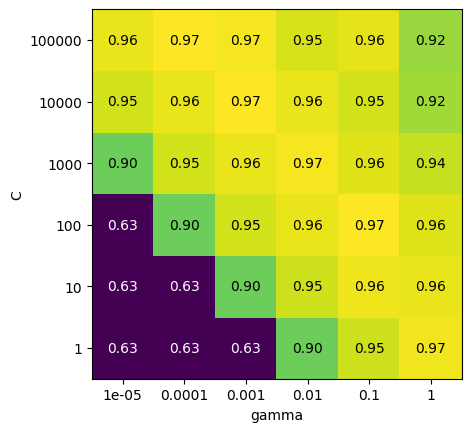

In [6]:
results = pd.DataFrame(grid.cv_results_)
scores = np.array(results.mean_test_score).reshape(6, 6)
mglearn.tools.heatmap(scores, 
                      xlabel='gamma', 
                      xticklabels=param_grid['svm__gamma'], 
                      ylabel='C', 
                      yticklabels=param_grid['svm__C'], 
                      cmap="viridis");

En el mapa de calor se observan los scores que se obtiene al usar SVM variando cada uno de los parametros. Considerando que las zonas iluminadas se encuentran en el centro del mapa no parece necesario ajustar los valores de gamma y C.

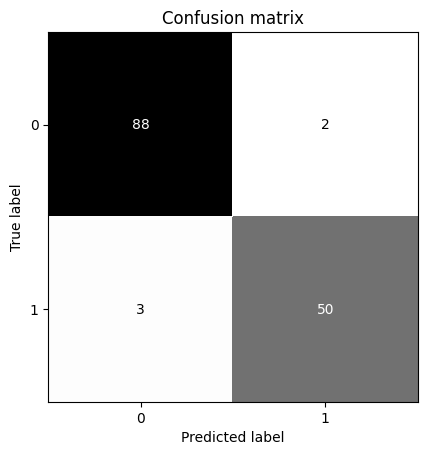

In [7]:
pred=grid.predict(X_test)
scores_image = mglearn.tools.heatmap(confusion_matrix(y_test, pred), 
                                     xlabel='Predicted label',
                                     ylabel='True label', 
                                     xticklabels=[0,1],
                                     yticklabels=[0,1],
                                     cmap=plt.cm.gray_r, 
                                     fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

Una vez seleccionado el mejor modelo, se evalúan examinan los casos clasificados correctamente. Se observa que de los 53 casos con cancer detectó 50 y los 90 casos sin cancer detectó 88.

In [8]:
precision, recall, thresholds = precision_recall_curve(y_test, grid.decision_function(X_test))
close_zero = np.argmin(np.abs(thresholds))

In [9]:
print("f1_score de SVM: {:.3f}".format(f1_score(y_test, grid.predict(X_test))))

f1_score de SVM: 0.952


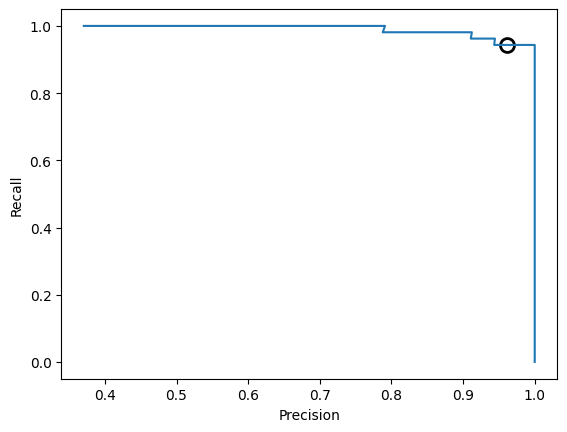

In [10]:
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(precision, recall, label="precision recall curve SVM")
plt.xlabel("Precision")
plt.ylabel("Recall");

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, grid.decision_function(X_test))
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=500, height=500)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

Una vez se observan los casos clasificados correctamente, es necesario examinar la curva ROC la cual muestra la relación entre las clasificaciones correctas e incorrectas. Asimismo, el AUC es un valor que oscila entre 0 y 1. Valores cercanos a 1 indican mayor calidad del modelo. En este caso el AUC de 0.996 muestra que el modelo resulta bastante bueno.

### Modelo de regresión logística

Ya se evaluó la capacidad de clasificar de SVM siendo esta de 96.5% para los datos de testeo. A continuación se realiza el mismo procedimiento, pero implementendo modelos de regresión logística para determinar si este clasifica mejor que SVM.

In [12]:
param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

pipe = Pipeline([("scaler", MinMaxScaler()), ("PCA", PCA(n_components=4)), ("logisticregression", LogisticRegression())])
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs = -1)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.97
Test set score: 0.965
Best parameters: {'logisticregression__C': 100}


Los resultados muestran que este modelo clasifica correctamente 96.5% de los datos de testeo tal como el SVM.

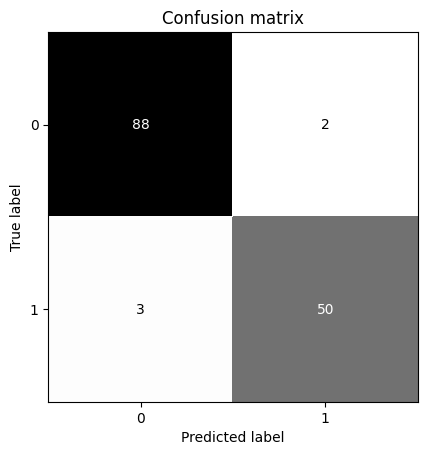

In [13]:
pred=grid.predict(X_test)
scores_image = mglearn.tools.heatmap(confusion_matrix(y_test, pred), 
                                     xlabel='Predicted label',
                                     ylabel='True label', 
                                     xticklabels=[0,1],
                                     yticklabels=[0,1],
                                     cmap=plt.cm.gray_r, 
                                     fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

La matriz de confusión muestra que el modelo logístico solo tuvo 3 falsos negativos y 2 falsos positivos.

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, grid.decision_function(X_test))
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=500, height=500)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [15]:
precision, recall, thresholds = precision_recall_curve(y_test, grid.decision_function(X_test))
close_zero = np.argmin(np.abs(thresholds))

In [16]:
print("f1_score de Regresion logistica: {:.3f}".format(f1_score(y_test, grid.predict(X_test))))

f1_score de Regresion logistica: 0.952


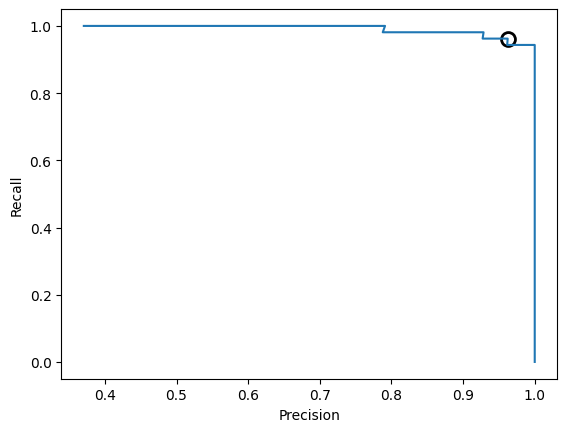

In [17]:
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(precision, recall, label="precision recall curve Logistica")
plt.xlabel("Precision")
plt.ylabel("Recall");

El AUC del modelo logístico muestra ser superior al de SVM.

### Modelo XG Boosting

In [18]:
random.seed(10)
param_grid = {'Gradient_boosting__n_estimators': [10, 20, 30, 40, 50, 55, 60, 65, 80]}

pipe = Pipeline([("scaler", MinMaxScaler()), ("PCA", PCA(n_components=4)), ("Gradient_boosting", xgb.XGBClassifier(objective="binary:logistic", booster='gblinear', learning_rate =0.1, eval_metric="auc"))])

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs = -1)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.97
Test set score: 0.965
Best parameters: {'Gradient_boosting__n_estimators': 80}


Al igual que el modelo de SVM, este modelo clasifica correctamente el 96% de los datos de testeo.

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, grid.predict_proba(X_test)[:,1])
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=500, height=500)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

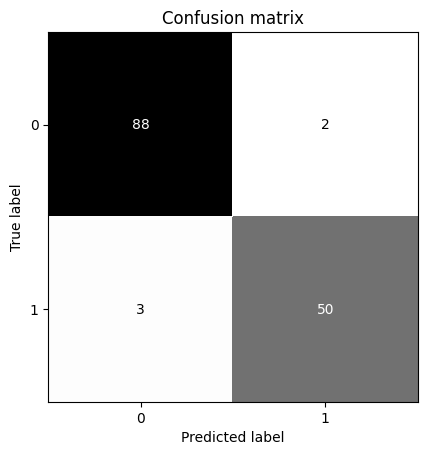

In [20]:
pred=grid.predict(X_test)
scores_image = mglearn.tools.heatmap(confusion_matrix(y_test, pred), 
                                     xlabel='Predicted label',
                                     ylabel='True label', 
                                     xticklabels=[0,1],
                                     yticklabels=[0,1],
                                     cmap=plt.cm.gray_r, 
                                     fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [21]:
precision, recall, thresholds = precision_recall_curve(y_test, grid.predict_proba(X_test)[:,1])
close_zero = np.argmin(np.abs(thresholds))

In [22]:
print("f1_score de XGBoosting: {:.3f}".format(f1_score(y_test, grid.predict(X_test))))

f1_score de XGBoosting: 0.952


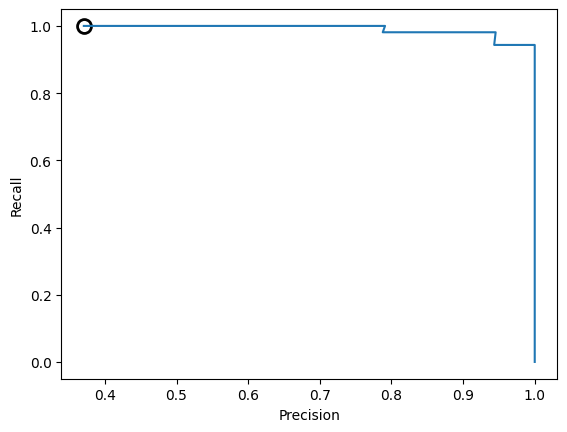

In [23]:
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(precision, recall, label="precision recall curve XGBoosting")
plt.xlabel("Precision")
plt.ylabel("Recall");

La matriz de confusión muestra que el modelo XGB solo tuvo 4 falsos negativos (una más que el modelo logístico) y 2 falsos positivos.

### Modelo RandomForestClassifier

In [24]:
pipe = Pipeline([('preprocessing', MinMaxScaler()), ("PCA", PCA(n_components=4)), ('classifier', RandomForestClassifier())])

param_grid = [{'classifier': [RandomForestClassifier(n_estimators=100)],

               'preprocessing': [None], 'classifier__max_features': [1, 2, 3, 4]}]

grid = GridSearchCV(pipe, param_grid, cv=5)

grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))

print("Best cross-validation score: {:.2f}".format(grid.best_score_))

print("Test-set score: {:.3f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': RandomForestClassifier(max_features=2), 'classifier__max_features': 2, 'preprocessing': None}

Best cross-validation score: 0.94
Test-set score: 0.965


Al ensayar con el Random Forest model, este clasifica correctamente el 95.1% de los datos de testeo (porcentaje menor que los modelos previos).

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, grid.predict_proba(X_test)[:,1])
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=500, height=500)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [26]:
precision, recall, thresholds = precision_recall_curve(y_test, grid.predict_proba(X_test)[:,1])
close_zero = np.argmin(np.abs(thresholds))

In [27]:
print("f1_score de Random Forest: {:.3f}".format(f1_score(y_test, grid.predict(X_test))))

f1_score de Random Forest: 0.952


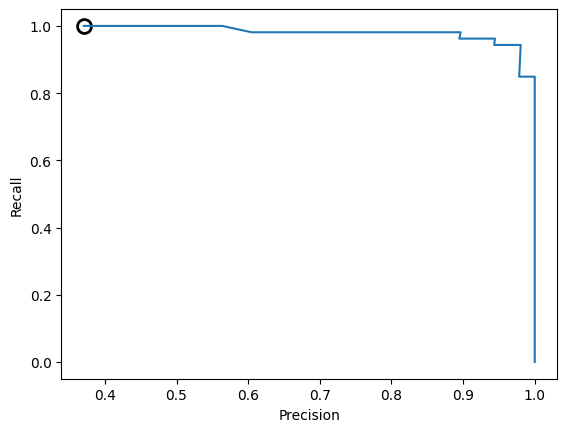

In [28]:
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(precision, recall, label="precision recall curve Random Forest")
plt.xlabel("Precision")
plt.ylabel("Recall");

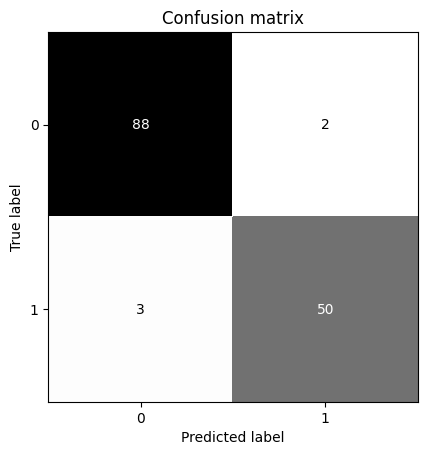

In [29]:
pred=grid.predict(X_test)
scores_image = mglearn.tools.heatmap(confusion_matrix(y_test, pred), 
                                     xlabel='Predicted label',
                                     ylabel='True label', 
                                     xticklabels=[0,1],
                                     yticklabels=[0,1],
                                     cmap=plt.cm.gray_r, 
                                     fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

La matriz de confusión del Random Forest model muestra 4 falsos negativos y 3 falsos positivos (mas que el XGB, M. Logistico y SVM).

El F1-score combina las medidas de precisión y exhaustividad, y devuelve una medida de calidad más general del modelo. El valor del F-Score oscila entre 0 (peor valor posible) y 1 (mejor valor posible). Siendo así, los modelos de SVM, el modelo de regresión logística y el XGboost los que arrojan el mejor f1-score y menores errores de clasificación. Aunque random forest mostró buenos scores fue el que mostró un peor desempeño al momento de clasificar los tumores.